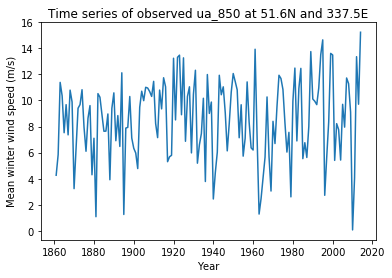

<xarray.Dataset>
Dimensions:  (lat: 776, lon: 3200, time: 1968)
Coordinates:
  * time     (time) float32 9.96921e+36 9.96921e+36 ... 9.96921e+36 9.96921e+36
  * lat      (lat) float32 9.96921e+36 9.96921e+36 ... 9.96921e+36 9.96921e+36
  * lon      (lon) float32 9.96921e+36 9.96921e+36 ... 9.96921e+36 9.96921e+36
Data variables:
    value    (time, lat, lon) float32 ...

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc 

ds_ws = xr.open_dataset("/rds/general/project/circulates/live/data/20CR/ua850_v2c_185101-201412.nc")
ds_pressure = xr.open_dataset("/rds/general/project/circulates/live/data/20CR/ps_v2c_185101-201412.nc")

#the chosen grid point is [time, 0, 13, 120] -> [time, 850.0, 51.6 N, 337.5 E]
#to access year use .dt.year
#print(type(ds_ua850.time[1].dt.year))
local_speed = np.array([])
for i in range(10, 164): #February, 2014 is 1957
    local_speed = np.append(local_speed, [np.average([float(ds_ws.ua[12*i-1, 0, 13, 120]), \
                                         float(ds_ws.ua[12*i, 0, 13, 120]), \
                                       float(ds_ws.ua[12*i+1, 0, 13, 120])])])
    
plt.plot(ds_ws.time[120:1957:12].dt.year, local_speed)
plt.title('Time series of observed ua_850 at 51.6N and 337.5E')
plt.ylabel('Mean winter wind speed (m/s)')
plt.xlabel('Year')
plt.show()

'''Filling in the unfilled coordinates''' 
#Creating equally spaced longitude array that includes real coordinates
lonss = np.empty([128*25])
for i in range(0, 128):
    if i == 127:
        lonss[(i*25):(i+1)*25] = np.linspace(ds_ws.lon[i], 360.0, 26)[0:-1] #interpolating up to 360
    else:
        lonss[(i*25):(i+1)*25] = np.linspace(ds_ws.lon[i], ds_ws.lon[i+1], 26)[0:-1]

#Creating equally spaced latitude array that includes real coordinates
latss = np.empty([31*25])
for i in range(0, 31):
    latss[(i*25):(i+1)*25] = np.linspace(ds_ws.lat[i], ds_ws.lat[i+1], 26)[0:-1]
latss = np.append(latss, ds_ws.lat[31])


(3200, 776, (776, 3200))
[-180.     -179.8875 -179.775  ...,  179.6625  179.775   179.8875]


<a list of 0 text.Text objects>

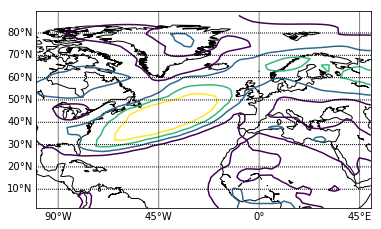

In [82]:
import os
os.environ["PROJ_LIB"] = "/rds/general/user/ib719/home/anaconda3/envs/test1/share/proj"
from mpl_toolkits.basemap import Basemap
ds_ua850 = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ws_interpolated.nc")

map = Basemap(projection='cyl',llcrnrlon=-100.,llcrnrlat=1.39,urcrnrlon=50.0,urcrnrlat=90.,resolution='c') 
#map = Basemap(projection='cyl',llcrnrlon=-180.,llcrnrlat=1.39,urcrnrlon=180.0,urcrnrlat=90.,resolution='c') 
# projection, lat/lon extents and resolution of polygons to draw
# resolutions: c - crude, l - low, i - intermediate, h - high, f - full
map.drawcoastlines()
map.drawparallels(np.arange(10, 81, 10), labels = [1,0,0,0])
map.drawmeridians(np.arange(-90, 46, 45), labels = [0,0,0,1])
ua = np.array(ds_ua850.value[111])
#ua = np.transpose(np.array(ua))
clevs = np.arange(0, 10, 3)
print(len(lonss), len(latss), ua.shape)
x, y = np.meshgrid(lonss, latss)
#cs = map.contour(x, y, np.roll(ua[:, :], shift = -1600, axis = 1), clevs, colour = 'b')
cs = map.contour(x, y, ua[:, :], clevs, colour = 'b', latlon = 1)
print(lonss-180)

arr = np.random.random((7,4))
clevs2 = np.array([0.1, 0.3, 0.5])
x, y = np.meshgrid(np.array([300.0, 301.0, 302.0, 303.0]), np.array([10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0]))
cs = map.contour(x-180, y, arr[:, :], clevs2, colour = 'b', latlon = 1)
plt.clabel(cs, fontsize=6, inline=2)

In [6]:
import time as tm
import scipy as sp
from scipy import signal 
import netCDF4 as nc
import numpy as np 
 
'''Creating a new windspeed file'''
start_time = tm.time()
old_lons = np.append(np.array(ds_ws.lon[:]), 360.0) #interpolating up to 360
print(old_lons.shape)
print(np.array(ds_ws.lat[0:32]).shape)
temporary_vals_1 = np.empty([1968, 129, 32])
temporary_vals_2 = np.empty([32, 3200])
temporary_vals_3 = np.empty([3200, 776])
vals = np.empty([1968, 32, 129])
print(vals.shape)

'''
#the procedure would take 5 hours to run, but will maintain the structure (lat, lon)
for i in range(0, 1968):
    print("Writing data: --- %s seconds ---" % (tm.time() - start_time))
    for j in range(0, 32):
        for k in range(0, 129):
            if k == 128:
                val[i][j][k] = np.float(ds_ws.ua[i, 0, j, 0])
            else:
                val[i][j][k] = np.float(ds_ws.ua[i, 0, j, k])   
'''

for i in range(0, 1968):
    temporary_vals_1[i][:-1][:] = np.transpose(np.array(ds_ws.ua[i, 0, 0:32 , :])) #transposing because the first comes longitude
    temporary_vals_1[i][128][:] = np.array(ds_ws.ua[i, 0, 0:32, 0])
    vals[i][:][:] = np.transpose(temporary_vals_1[i][:][:]) #transposing back to lat, lon
    
print("New values are ready: --- %s seconds ---" % (tm.time() - start_time))

#Interpolating
path = "/rds/general/user/ib719/home/UROP_2021/ws_interpolated2.nc"
ds_ua850 = nc.Dataset(path, 'w', format = 'NETCDF4')
time = ds_ua850.createDimension('time', 1968)
lat = ds_ua850.createDimension('lat', 31*25+1)
lon = ds_ua850.createDimension('lon', 128*25)

times = ds_ua850.createVariable('time', np.float32, ('time',))
lats = ds_ua850.createVariable('lat', np.float32, ('lat',))
lons = ds_ua850.createVariable('lon', np.float32, ('lon',))
value = ds_ua850.createVariable('value', np.float32, ('time', 'lat', 'lon',))
value.units = 'm/s'
times = ds_ws.time[:]

#Creating equally spaced longitude array that includes real coordinates
lons = np.empty([128*25])
for i in range(0, 128):
    if i == 127:
        lons[(i*25):(i+1)*25] = np.linspace(ds_ws.lon[i], 360.0, 26)[0:-1] #interpolating up to 360
    else:
        lons[(i*25):(i+1)*25] = np.linspace(ds_ws.lon[i], ds_ws.lon[i+1], 26)[0:-1]

#Creating equally spaced latitude array that includes real coordinates
lats = np.empty([31*25])
for i in range(0, 31):
    lats[(i*25):(i+1)*25] = np.linspace(ds_ws.lat[i], ds_ws.lat[i+1], 26)[0:-1]
lats = np.append(lats, ds_ws.lat[31])

#new resolution: 0.1125 x 0.1116 
for i in range(0, 1968):
    #value[i] = sp.interpolate.griddata((np.array(ds_ws.lat[0:32]), old_lons), vals[i], (lats, lons))
    for j in range(0, 32):
        temporary_vals_2[j][:] = sp.interpolate.griddata(old_lons, vals[i][j][:], lons)
    temporary_vals_2 = np.transpose(temporary_vals_2)
    for j in range(0, 3200):
        temporary_vals_3[j][:] = sp.interpolate.griddata(np.array(ds_ws.lat[0:32]), temporary_vals_2[j][:], lats)
    value[i, :, :] = np.transpose(temporary_vals_3)
    temporary_vals_2 = np.transpose(temporary_vals_2)
    if i % 100 == 0:
        print("Interpolating, %d: --- %s seconds ---" % (i, tm.time() - start_time))

ds_ua850.close()
print("Total time: --- %s seconds ---" % (tm.time() - start_time))

SyntaxError: invalid syntax (<ipython-input-6-3a18a8c8770c>, line 1)

In [ ]:
import time
import scipy as sp
from scipy import signal 
import netCDF4 as nc
import numpy as np 

start_time = time.time()

ds_ua850 = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ws_interpolated.nc")
ds_ua850['time'] = dw_ws.time
ds_ua850['lat'] = latss
ds_ua850['lon'] = lonss
    
'''Defining useful terms'''
lon_ws_D = np.empty([14])
lon_ws_F = np.empty([14])
lon_ws_J = np.empty([14])
lat_ws_D = np.empty([32])  
lat_ws_J = np.empty([32])  
lat_ws_F = np.empty([32])

jet_strength = np.empty([154])
jet_latitude = np.empty([154])
NAO_index = np.empty([154])
header_param = "Year\t\tLatitude\tStrength\tNAO_index"

'''Winter mean NetCDF file'''
path = "/rds/general/user/ib719/home/UROP_2021/ws_winter.nc"
avg_ws = nc.Dataset(path, 'w', format = 'NETCDF4')
time = avg_ws.createDimension('time', 154)
lat = avg_ws.createDimension('lat', 31*25+1)
lon = avg_ws.createDimension('lon', 128*25)

times = avg_ws.createVariable('time', np.float32, ('time',))
lats = avg_ws.createVariable('lat', np.float32, ('lat',))
lons = avg_ws.createVariable('lon', np.float32, ('lon',))
value = avg_ws.createVariable('value', np.float32, ('time', 'lat', 'lon',))
value.units = 'm/s'
times[:] = np.arange(1861, 2015)
lats[:] = latss
lons[:] = lonss

for i in range(10, 164): # Number of years from 1861 to 2014
    for j in range(0, 776): # Latitude points from 87.9d N to 1.4dN
        for k in range(114, 128): # Longitude points from 300.9d E to 357.2d E 
            # Longitude array of mean winter ws at a j-th latitude
            lon_ws_D[k-114] = ds_ua850.ua[(12*i-1), 0, j, k]]
            lon_ws_J[k-114] = ds_ua850.ua[(12*i), 0, j, k]]
            lon_ws_F[k-114] = ds_ua850.ua[(12*i+1), 0, j, k]]
        lat_ws_D[j] = np.average(lon_ws_D) # Latitude array of longitudinal monthly values
        lat_ws_J[j] = np.average(lon_ws_J)
        lat_ws_F[j] = np.average(lon_ws_F)
        for k in range(0, 52): # Values for avg_ws.nc
            if k <= 16:
                value[i-10, j, k] = np.average([ds_ua850.ua[(12*i-1):(12*i+2), 0, j, k]])
            else:
                value[i-10, j, k] = np.average([ds_ua850.ua[(12*i-1):(12*i+2), 0, j, k+76]])
    jet_strength[i-10] = np.average([max(lat_ws_D), max(lat_ws_J), max(lat_ws_F)])
    jet_latitude[i-10] = np.average([ds_ua850.lat[np.where(lat_ws_D == max(lat_ws_D))], \
                                     ds_ua850.lat[np.where(lat_ws_J == max(lat_ws_J))], \
                                     ds_ua850.lat[np.where(lat_ws_F == max(lat_ws_F))]])
    azores_ps = ds_pressure.ps[(12*i-1):(12*i+2), 8, 121] # Azores DJF
    iceland_ps = ds_pressure.ps[(12*i-1):(12*i+2), 18, 119] # Iceland DJF
    NAO_index[i-10] = np.average(iceland_ps - azores_ps)/100 # Division by 100 to convert into hPa
    print("Year %d: --- %s seconds ---" % (1851+i, time.time() - start_time))
    
params = np.column_stack([ds_ua850.time[120:1957:12].dt.year, jet_latitude, jet_strength, NAO_index])
np.savetxt('parameters.txt', params, fmt = '%.5f', delimiter = '\t', header = header_param, comments = '')
print('Parameters are saved')

plt.xlabel('Year')
plt.ylabel('Jet Strength (m/s)')
plt.title('Jet Strength oscillations (1861-2014)')
plt.plot(ds_ua850.time[120:1957:12].dt.year, jet_strength, color = 'red')
plt.show()
plt.xlabel('Year')
plt.ylabel('Jet Latitude (deg)')
plt.title('Jet Latitude oscillations (1861-2014)')
plt.plot(ds_ua850.time[120:1957:12].dt.year, jet_latitude, color = 'green')
plt.show()
plt.xlabel('Year')
plt.ylabel('NAO point index (hPa)')
plt.title('Variation of NAO index (1861-2014)')
plt.plot(ds_ua850.time[120:1957:12].dt.year, NAO_index, color = 'blue')
plt.show()

print("Total time: --- %s seconds ---" % (time.time() - start_time))

In [26]:
""" Regression Analysis """
import time
import scipy as sp
from scipy import signal 
import netCDF4 as nc

# jet_stength2 = signal.detrend(jet_strength)
# jet_latitude2 = signal.detrend(jet_latitude)
# NAO_index2 = signal.detrend(NAO_index)

start_time = time.time()

years, jet_latitude, jet_strength, NAO_index = np.loadtxt("Parameters.txt", skiprows = 1, unpack = True)
jet_stength_de = signal.detrend(jet_strength)
jet_latitude_de = signal.detrend(jet_latitude)
NAO_index_de = signal.detrend(NAO_index)

avg_ws = np.loadtxt("wind_speed.txt", skiprows = 1, unpack = True)


fit1, cov1 = sp.polyfit(x1[0], y1[0], 1, cov = True) #1 stands for the degree of a polynomial 
fit2, cov2 = sp.polyfit(x2[0], y2[0], 1, cov = True)

print(fit1[0], ' & ', fit2[0])
y3 = signal.detrend(y2)

print("--- %s seconds ---" % (time.time() - start_time))

(-0.7006558807032567, ' & ', -0.7006558807032559)
(array([[ 1.58088578, -0.3404862 , -0.94223509,  0.39189807, -0.49330999,
        -1.05703653,  0.4409582 ,  1.42090073,  0.39975073, -2.90134779]]), array([[ 1.58088578, -0.3404862 , -0.94223509,  0.39189807, -0.49330999,
        -1.05703653,  0.4409582 ,  1.42090073,  0.39975073, -2.90134779]]))


In [59]:
a = [[1.52, 2.13, 3.13], [4.2542, 5.00, 6.777], [3, 5, 6], [8, 6, 9]]
a = np.transpose(a)
np.savetxt('data.txt', a, fmt = '%.2f', delimiter = '\t', header = "HDA\t\tZeff\tchicha\treal", comments = '')

In [121]:
import xarray as xr
import netCDF4 as nc
import numpy as np

fn = '/rds/general/user/ib719/home/UROP_2021/test2.nc'
#dsa = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/test2.nc")
dsa = nc.Dataset(fn, 'w', format='NETCDF4')

time = dsa.createDimension('time', 10)
lat = dsa.createDimension('lat', 10)
lon = dsa.createDimension('lon', 10)

times = dsa.createVariable('time', 'f4', ('time',))
lats = dsa.createVariable('lat', 'f4', ('lat',))
lons = dsa.createVariable('lon', 'f4', ('lon',))
value = dsa.createVariable('value', np.float64, ('time', 'lat', 'lon',))
value.units = 'Unknown'

times[:] = np.arange(1861, 1871)
lats[:] = np.array(ds_ws.lat[0:10])
lons[:] = np.arange(-110.0, -100.0, 1.0)

value[0, :, :] = np.random.uniform(0, 100, size=(10, 10))
value[1, :, :] = np.random.uniform(0, 100, size=(10, 10))

ds.close()
#ds.time
#ds = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/test.nc")
#ds.time

In [122]:
ds = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/test2.nc")
ds.lat

<xarray.DataArray 'lat' (lat: 10)>
array([ 87.8638  ,  85.096527,  82.312912,  79.525604,  76.7369  ,  73.947517,
        71.157753,  68.36776 ,  65.577606,  62.787354], dtype=float32)
Coordinates:
  * lat      (lat) float32 87.8638 85.0965 82.3129 ... 68.3678 65.5776 62.7874

In [26]:
"""Proof that the coordinates are not spreaded equally (due to spherical geometry?)"""
b = np.array([87.8638  ,  85.096527,  82.312912,  79.525604,  76.7369  ,  73.947517,
        71.157753,  68.36776 ,  65.577606,  62.787354,  59.997021,  57.206631,
        54.416199,  51.625732,  48.835239,  46.044727,  43.254196,  40.46365 ,
        37.673088,  34.882523,  32.091946,  29.301359,  26.510769,  23.720175,
        20.929575,  18.138971,  15.348365,  12.557756,   9.767145,   6.976533,
         4.185921,   1.395307,  -1.395307,  -4.185921,  -6.976533,  -9.767145,
       -12.557756, -15.348365, -18.138971, -20.929575, -23.720175, -26.510769,
       -29.301359, -32.091946, -34.882523, -37.673088, -40.46365 , -43.254196,
       -46.044727, -48.835239, -51.625732, -54.416199, -57.206631, -59.997021,
       -62.787354, -65.577606, -68.36776 , -71.157753, -73.947517, -76.7369  ,
       -79.525604, -82.312912, -85.096527, -87.8638 ])

a = np.linspace(87.8638, -87.8638, 64)
print(a-b)

d = np.linspace(87.8638, 85.096527, 26)
print(d[10:12])

c = np.empty([31*25])
for i in range(0, 31):
    c[(i*25):(i+1)*25] = np.linspace(ds_ws.lat[i], ds_ws.lat[i+1], 26)[0:-1]
c = np.append(c, ds_ws.lat[31])
#print(c)

[ 0.         -0.02205398 -0.02776597 -0.02978495 -0.03040794 -0.03035192
 -0.0299149  -0.02924889 -0.02842187 -0.02749686 -0.02649084 -0.02542783
 -0.02432281 -0.02318279 -0.02201678 -0.02083176 -0.01962775 -0.01840873
 -0.01717371 -0.0159357  -0.01468568 -0.01342567 -0.01216265 -0.01089563
 -0.00962262 -0.0083456  -0.00706659 -0.00578457 -0.00450056 -0.00321554
 -0.00193052 -0.00064351  0.00064351  0.00193052  0.00321554  0.00450056
  0.00578457  0.00706659  0.0083456   0.00962262  0.01089563  0.01216265
  0.01342567  0.01468568  0.0159357   0.01717371  0.01840873  0.01962775
  0.02083176  0.02201678  0.02318279  0.02432281  0.02542783  0.02649084
  0.02749686  0.02842187  0.02924889  0.0299149   0.03035192  0.03040794
  0.02978495  0.02776597  0.02205398  0.        ]
[ 86.7568908   86.64619988]
